# Term Deposit Subscription 
Muhammad Najmi Naufal

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.<br/>
<br/>
The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).<br/>
<br/>
Dataset: bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]<br/>
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing<br/>
<br/>
Source: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

## Import Libraries

In [1]:
# general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [2]:
# sklearn and other modules
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score, RocCurveDisplay 

## Data Loading

In [3]:
# load dataset as pandas DataFrame
df = pd.read_csv('bank-additional-full.csv', sep=';')

Input variables:<br/>
<br/>
bank client data:<br/>
1 - age<br/>
2 - job : type of job<br/>
3 - marital : marital status<br/>
4 - education<br/>
5 - default: has credit in default?<br/> 
6 - housing: has housing loan?<br/> 
7 - loan: has personal loan?<br/> 
<br/>
related with the last contact of the current campaign:<br/>
8 - contact: contact communication type<br/>
9 - month: last contact month of year<br/> 
10 - day_of_week: last contact day of the week<br/> 
11 - duration: last contact duration, in seconds<br/>
<br/>
other attributes:<br/>
12 - campaign: number of contacts performed during this campaign and for this client<br/>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign<br/> 
14 - previous: number of contacts performed before this campaign and for this client<br/>
15 - poutcome: outcome of the previous marketing campaign<br/>
<br/>
social and economic context attributes<br/>
16 - emp.var.rate: employment variation rate - quarterly indicator<br/>
17 - cons.price.idx: consumer price index - monthly indicator<br/> 
18 - cons.conf.idx: consumer confidence index - monthly indicator<br/>
19 - euribor3m: euribor 3 month rate - daily indicator<br/> 
20 - nr.employed: number of employees - quarterly indicator<br/> 
<br/>
Output variable (desired target):<br/>
21 - y - has the client subscribed a term deposit?<br/>
<br/>
Important note:<br/> 
11 - This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br/>
13 - 999 means client was not previously contacted

In [4]:
# original dataset copy
data = df.copy()
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# columns name, number of non-nulls, and data type 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Each column in dataset correspondents with an input variable, keep in mind the number of columns starts at zero. At first glance, the dataset doesn't contain any nulls.

In [6]:
# number of unique values in columns
data.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

There aren't any identity column in dataset. The dataset index can be dropped to a new column, which can also works as a time-based variable since the dataset is ordered by date.

In [7]:
# general statistic description
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


The majority of samples have not been contacted before, as shown by the statistic description of column 'pdays'. The uncontacted value (999) in this column will be reordered to the minimum (-1), hopefully the data distribution will make more sense.

In [8]:
# create identity column from original index
data.reset_index(inplace=True)
data.rename(columns = {'index':'time_order'}, inplace=True)

# replace value in 'pdays'
data.pdays.replace(999, -1, inplace=True)

# replace 'y' atributes to numeric
data['y'] = data.y.map(dict(no=0, yes=1))

To prevent any information leakage, inference, train, and test data will be split from the dataset. Stratify keeps the ratio between 'yes' and 'no' in both train and test data.

In [9]:
# split inference data
data_inf = data.sample(100, random_state=17)
data_train_test = data.drop(data_inf.index)

data_inf.reset_index(drop=True, inplace=True)
data_train_test.reset_index(drop=True, inplace=True)

# split train / test data
data_train, data_test = train_test_split(data_train_test, test_size=0.2, random_state=17, stratify=data_train_test['y'])

print('train data shape :', data_train.shape)
print('test data shape  :', data_test.shape)

train data shape : (32870, 22)
test data shape  : (8218, 22)


## Exploratory Data Analysis (EDA)

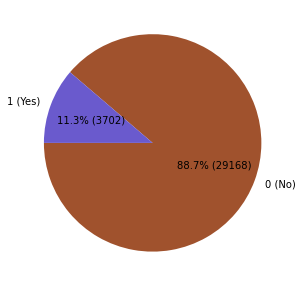

In [10]:
# 'y' data distribution
target_counts = data_train.y.value_counts().sort_index()

plt.figure(figsize=(5, 5))
labels = ['0 (No)', '1 (Yes)']
colors = ['Sienna', 'SlateBlue']
plt.pie(target_counts, labels=labels, colors=colors, startangle=180, 
        autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*target_counts.sum()))
plt.show()

The ratio between 'yes' and 'no' is almost 1:8, which is quite imbalance. There is an almost certainty that the model prefers to classify the data as 'no' rather than 'yes'.

In [11]:
# 'y' correlation table
data_train.corr()['y'].sort_values(ascending=False)

y                 1.000000
duration          0.405829
time_order        0.293321
pdays             0.272491
previous          0.227296
cons.conf.idx     0.058305
age               0.029396
campaign         -0.066948
cons.price.idx   -0.138113
emp.var.rate     -0.298652
euribor3m        -0.307220
nr.employed      -0.353773
Name: y, dtype: float64

The target data has a positive correlation with 'time_order', thus the samples from later dates are more likely to subsribe. The social economic variables change periodically, these variables can be plotted against 'time_order'. 

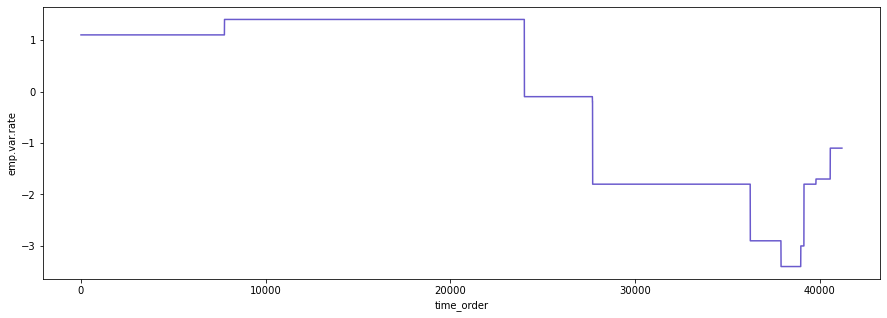

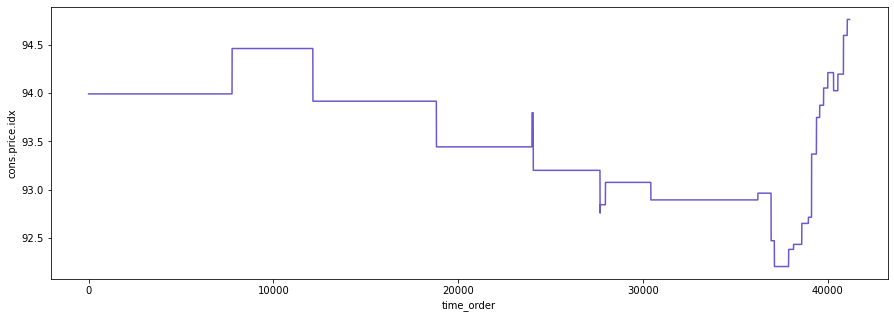

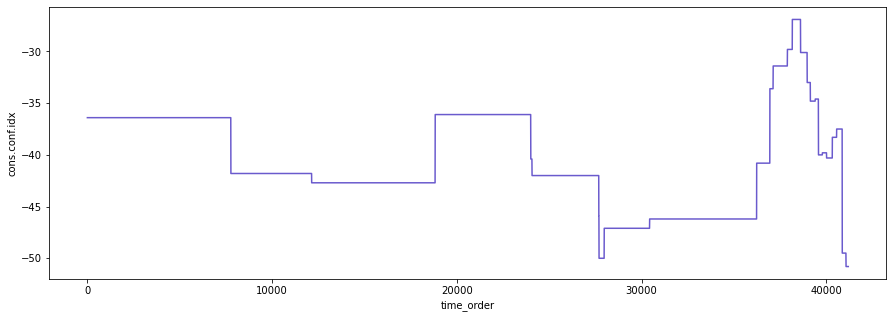

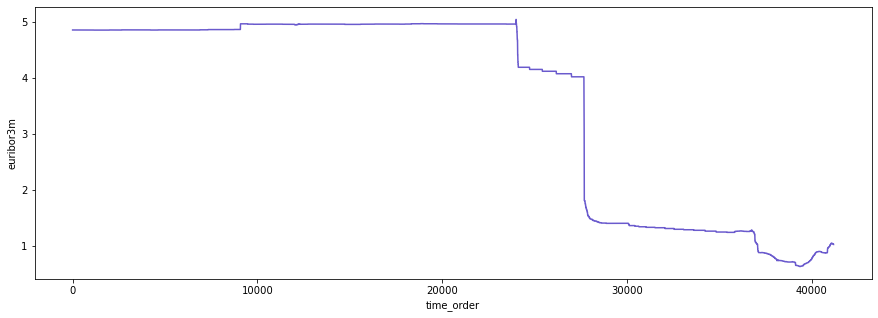

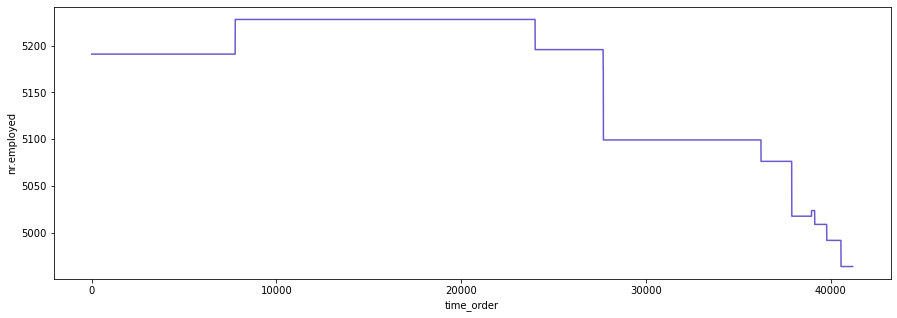

In [12]:
# social economic columns
social_economic = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# 'time_order' plots
for col in social_economic:
    plt.figure(figsize=(15, 5))
    sns.lineplot(x='time_order', y=col, data=data_train, color='SlateBlue')
    plt.show()

All variables display a drop in value at a certain time, most notably 'euribor3m'.

In [13]:
# 'euribor3m' rate change
euribor3m_pre = data_train[data_train.euribor3m > 2][['time_order', 'month', 'euribor3m']].sort_values(by=['time_order']).tail(1)
euribor3m_post = data_train[data_train.euribor3m < 2][['time_order', 'month', 'euribor3m']].sort_values(by=['time_order']).head(1)
pd.concat([euribor3m_pre, euribor3m_post])

,time_order,month,euribor3m
27625,27689,dec,3.053
27627,27691,mar,1.811


The 'euribor3m' plummets in span of a few months with no sample available. There must be something happening in those months. Let's find out more about euribor. 

Euribor is the acronym for the Euro Interbank Offered Rate. This is the interest rate at which credit institutions lend money to each other, which is often referred to as “the price of money”.<br/>
<br/>
The Euribor is published daily, but does not really refer to a single interest rate. It is actually an average of the rates at which European banks lend money to each other over a particular period. There is a Euribor value for each of the defined Euribor terms: one week, one month, three months, six months and twelve months. The monthly average for the 12-month Euribor is the most commonly used as a benchmark for mortgages.<br/>
<br/>
The Euribor is calculated by the European Money Markets Institute from the interest rates it requests every day from each of the banks in the euro zone.The Euribor is calculated by eliminating the highest 15% and the lowest 15% of the interest rates submitted and calculating the arithmetic mean of the remaining values.[1]<br/>
<br/>
Since the Euribor rates are based upon agreements between many European banks, the level of the rates is determined by supply and demand in the first place. However there are some external factors, like economic growth and inflation which do influence the level of the rates as well.[2]<br/>
<br/>
[1] https://www.bankinter.com/banca/en/faqs/mortgages/what-is-euribor-and-how-does-it-affect-me<br/>
[2] https://www.euribor-rates.eu/en/what-is-euribor/#:~:text=Since%20the%20Euribor%20rates%20are,of%20the%20rates%20as%20well.

In [14]:
# pre and post train data 
data_train_pre =  data_train[data_train.euribor3m > 1.811]
data_train_post =  data_train[data_train.euribor3m <= 1.811]

# pre and post train data information
print('euribor3m-pre train data rows  :', data_train_pre.shape[0])
print('euribor3m-post train data rows :', data_train_post.shape[0])
print('')
print('euribor3m-pre subscription rate  :', data_train_pre.y.mean())
print('euribor3m-post subscription rate :', data_train_post.y.mean())

euribor3m-pre train data rows  : 22065
euribor3m-post train data rows : 10805

euribor3m-pre subscription rate  : 0.04840244731475187
euribor3m-post subscription rate : 0.24377602961591854


In the web link below, there's a graph of euribor3m rate from January 1994 to June 2021. The graph shows a spike between 2005 and 2008, then rapidly decline in early 2009. This correspondents with a well-known financial crisis in europe during those period.<br/>
https://www.investopedia.com/terms/e/euribor.asp

People are less inclined to invest when the economy is down bad. There are less than 5 percent of samples that subscribe during high 'euribor3m' rate, while almost a quarter of samples are subscribing after the 'euribor3m' rate declines. This make any data with high 'euribor3m' rate unsuitable for modeling, thus ommited.

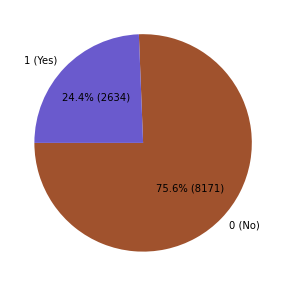

In [15]:
# 'y' data distribution (post)
target_counts = data_train_post.y.value_counts().sort_index()

plt.figure(figsize=(5, 5))
labels = ['0 (No)', '1 (Yes)']
colors = ['Sienna', 'SlateBlue']
plt.pie(target_counts, labels=labels, colors=colors, startangle=180, 
        autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*target_counts.sum()))
plt.show()

In [16]:
# 'y' correlation table (post)
data_train_post.corr()['y'].sort_values(ascending=False)

y                 1.000000
duration          0.356449
time_order        0.283473
pdays             0.270401
cons.conf.idx     0.269647
previous          0.157176
cons.price.idx    0.153208
age               0.087295
campaign         -0.085670
emp.var.rate     -0.140137
euribor3m        -0.306697
nr.employed      -0.342363
Name: y, dtype: float64

In both correlation table, 'age' and 'campaign' have a low correlation with 'y'. There should be a non-linear relation between those variables.

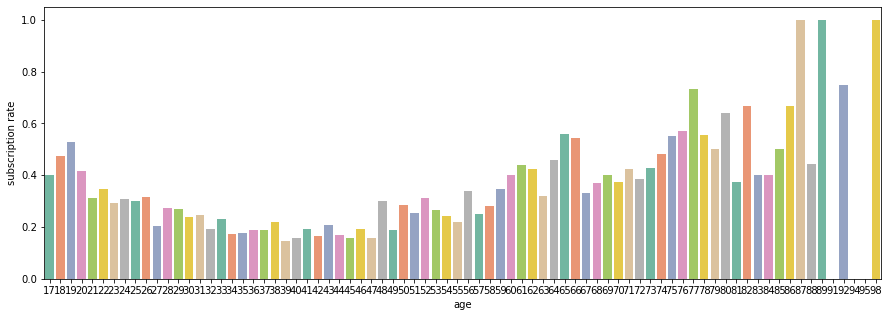

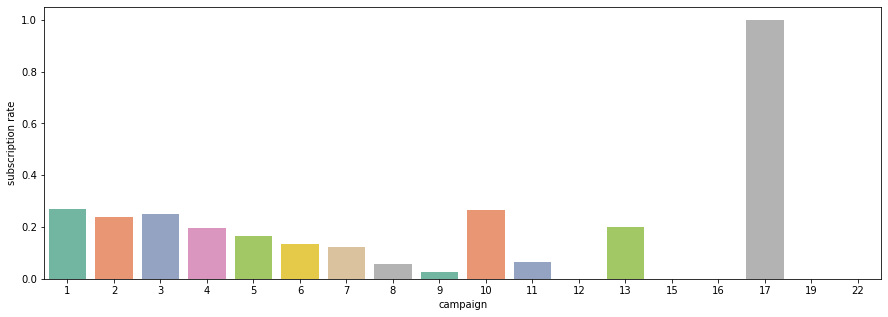

In [17]:
# check columns list
check_col = ['age','campaign']

# subsription rate graph of check columns
for col in check_col:
    check_means = pd.DataFrame({'subscription rate' : data_train_post.groupby(col)['y'].mean()}).reset_index()
    
    plt.figure(figsize=(15, 5))
    sns.barplot(x=col, y='subscription rate', data=check_means, palette='Set2')
    plt.show()

Indeed the relation to 'y' isn't linear. the values in these columns can be grouped into a new categorical column.

In [18]:
# age column grouping function
def age_group_col(df):
    age_series = pd.Series([], dtype='object')

    for i in df.index.to_list():
        if df['age'][i] > 66:
            age_series[i] = 'over 66'
        elif df['age'][i] > 56:
            age_series[i] = '57-66'
        elif df['age'][i] > 46:
            age_series[i] = '47-56'
        elif df['age'][i] > 36:
            age_series[i] = '37-46'
        elif df['age'][i] > 26:
            age_series[i] = '27-36'    
        else:
            age_series[i] = 'under 27'

    df['age_group'] = age_series

In [19]:
# campaign column grouping function
def campaign_group_col(df):
    campaign_series = pd.Series([], dtype='object')

    for i in df.index.to_list():
        if df['campaign'][i] > 5:
            campaign_series[i] = 'over 5'
        elif df['campaign'][i] > 3:
            campaign_series[i] = '4,5'
        elif df['campaign'][i] > 1:
            campaign_series[i] = '2,3'
        else:
            campaign_series[i] = '1'

    df['campaign_group'] = campaign_series

In [20]:
# category data plotting function (distribution, subsription rate)
def cat_plots(df, col, target):
    col_counts = df[col].value_counts().sort_index()
    target_means = pd.DataFrame({'subscription rate' : df.groupby(col)[target].mean()}).reset_index()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title(col)
    labels = col_counts.index
    colors = sns.color_palette('Set2')
    plt.pie(col_counts, labels=labels, colors=colors, startangle=180, 
            autopct=lambda p: '{:.1f}%'.format(p,(p/100)*col_counts.sum()))
    
    plt.subplot(1, 2, 2)
    cat_barplot = sns.barplot(x=col, y='subscription rate', data=target_means, palette='Set2')
    cat_barplot.set_xticklabels(cat_barplot.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.show() 

In [21]:
# age, campaign grouping of data_train_post
age_group_col(data_train_post)
campaign_group_col(data_train_post)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10884/1077067938.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_group'] = age_series
C:\Users\ASUS\AppData\Local\Temp/ipykernel_10884/2325953423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['campaign_group'] = campaign_series


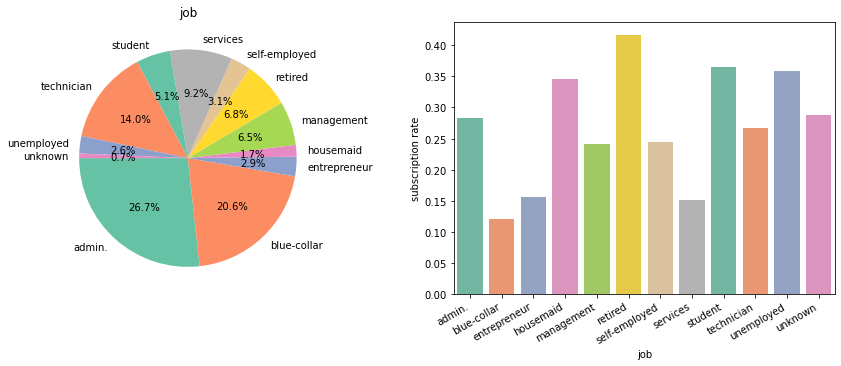

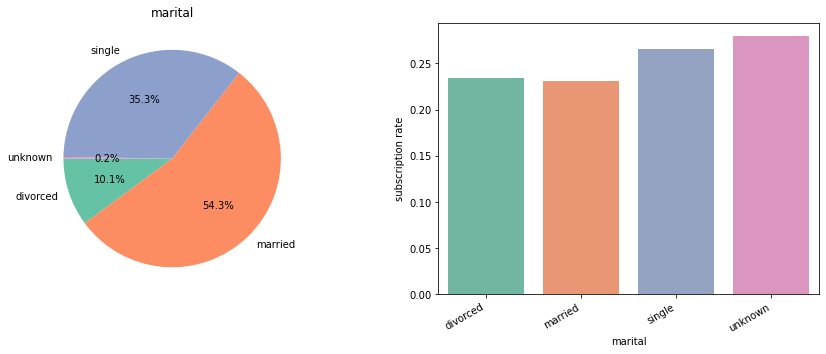

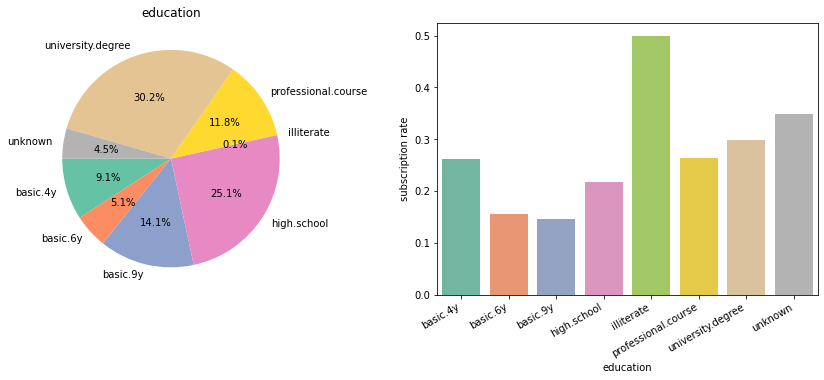

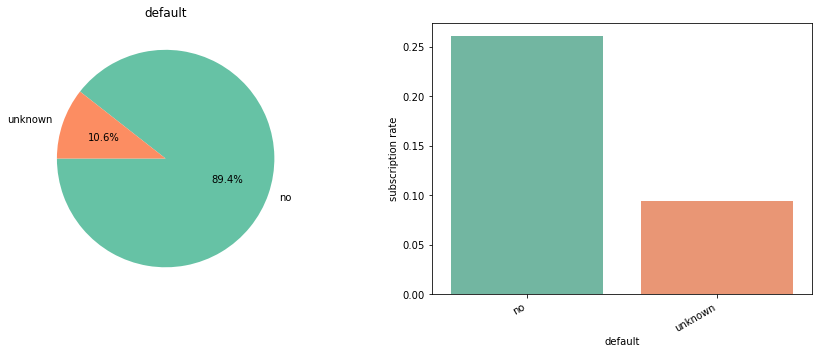

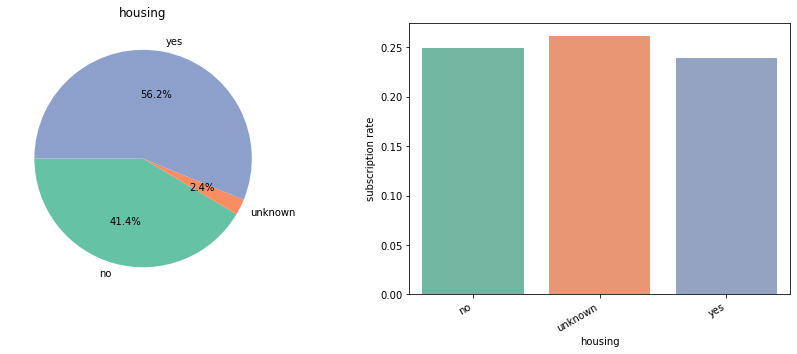

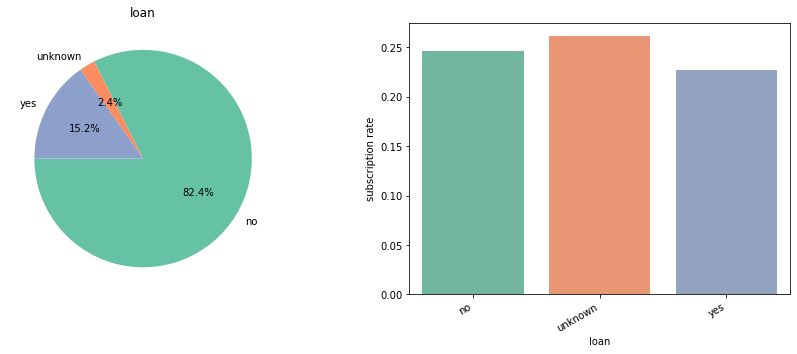

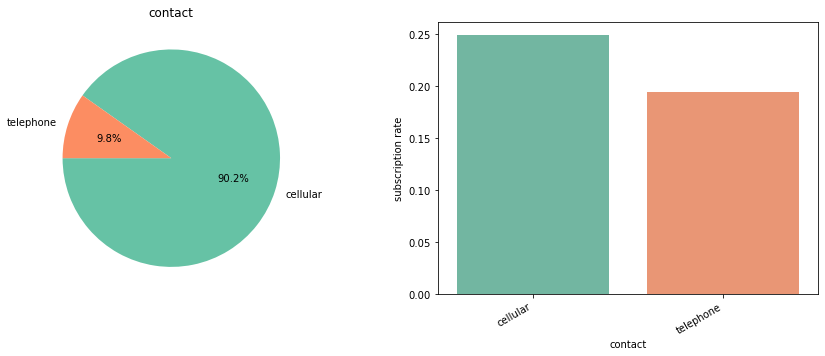

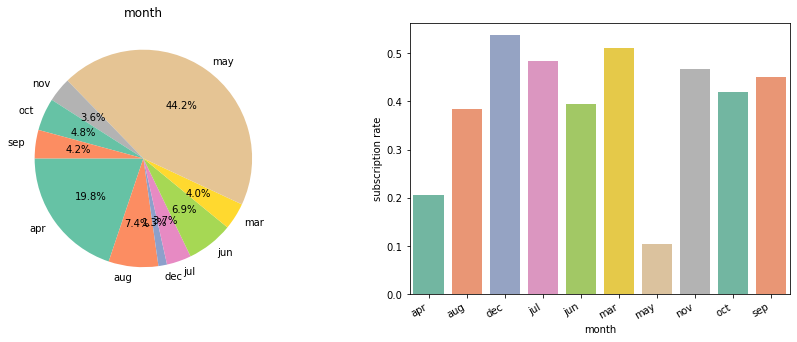

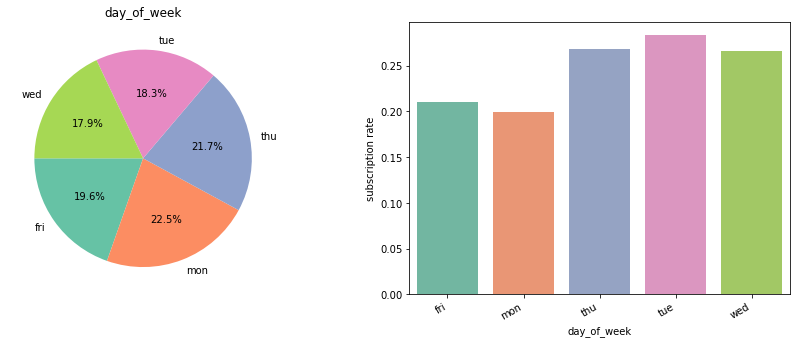

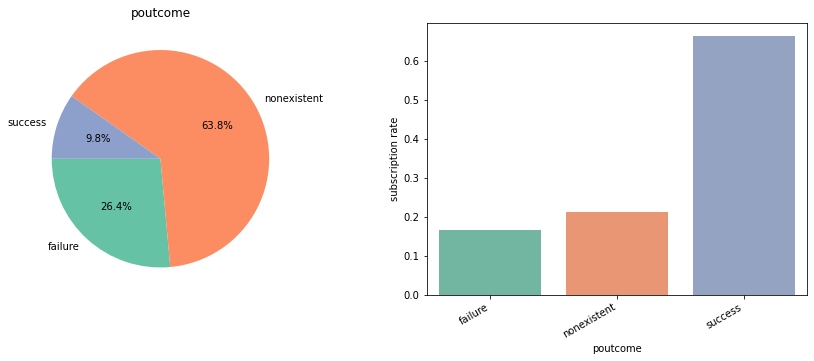

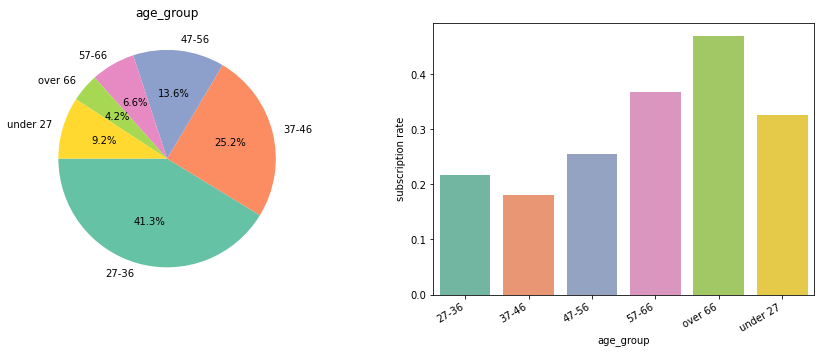

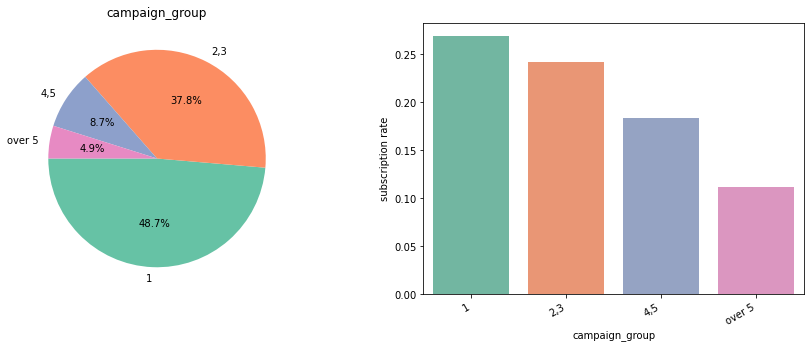

In [22]:
# category columns list
cat_col = data_train_post.select_dtypes(include=['object', 'category']).columns.tolist()

# category data plotting of category columns
for col in cat_col:
    cat_plots(data_train_post, col, 'y')

Any unique value with less than 1% occurance will be merged with similar unique values to reduce cardinality. 

## Data Preprocessing

Objectives of data preprocessing:
1. Cardinality Reduction
2. Target Splitting
3. Outlier Handling
4. Missing Value Handling (there shouldn't be any)
5. Feature Selection
6. Scaling and Encoding

### Cardinality Reduction

In [23]:
# post test data
data_test_post =  data_test[data_test.euribor3m <= 1.811]

# age, campaign grouping of data_test_post
age_group_col(data_test_post)
campaign_group_col(data_test_post)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10884/1077067938.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_group'] = age_series
C:\Users\ASUS\AppData\Local\Temp/ipykernel_10884/2325953423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['campaign_group'] = campaign_series


In [24]:
# merging rare unique values
data_train_post.job.replace('unknown','unemployed', inplace=True)
data_train_post.marital.replace('unknown','single', inplace=True)
data_train_post.education.replace('illiterate','unknown', inplace=True)
data_train_post.default.replace('yes','unknown', inplace=True)

data_test_post.job.replace('unknown','unemployed', inplace=True)
data_test_post.marital.replace('unknown','single', inplace=True)
data_test_post.education.replace('illiterate','unknown', inplace=True)
data_test_post.default.replace('yes','unknown', inplace=True)

D:\anaconda3\envs\yes_milord\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### Target Splitting

In [25]:
# split target('y') data
x_train =data_train_post.drop(['y'], axis=1)
x_test = data_test_post.drop(['y'], axis=1)

y_train = data_train_post['y']
y_test = data_test_post['y']

### Outlier Handling

In [26]:
# diagnostic_plots function (histogram, boxplot)
def diagnostic_plots(df, var):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[var], bins=10)
    plt.title('histogram')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[var])
    plt.title('boxplot')

    plt.show()

In [27]:
# upper, lower boundary function (based on IQR)
def find_skewed_boundaries(df, var, fold):
    IQR = df[var].quantile(0.75) - df[var].quantile(0.25)
    upper_boundary = df[var].quantile(0.75) + (IQR * fold)
    lower_boundary = df[var].quantile(0.25) - (IQR * fold)
    
    return upper_boundary, lower_boundary

In [28]:
# outlier number, percentage function
def outlier_info (df, var, b_type):
    upper_boundary, lower_boundary = b_type[var]
    
    print(col)
    print('total number of data : {}'.format(len(df)))
    print('right end outliers   : {}'.format(len(df[df[var] > upper_boundary])))
    print('left end outliers.   : {}'.format(len(df[df[var] < lower_boundary])))
    print('% right end outliers : {}'.format(len(df[df[var] > upper_boundary]) / len(df) * 100))
    print('% left end outliers  : {}'.format(len(df[df[var] < lower_boundary]) / len(df) * 100))
    print('')

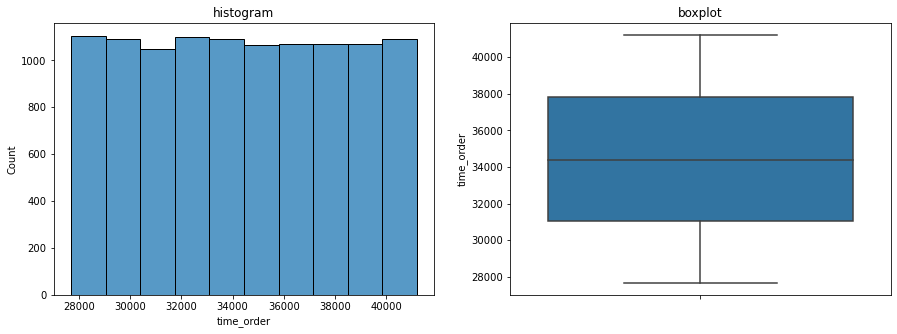

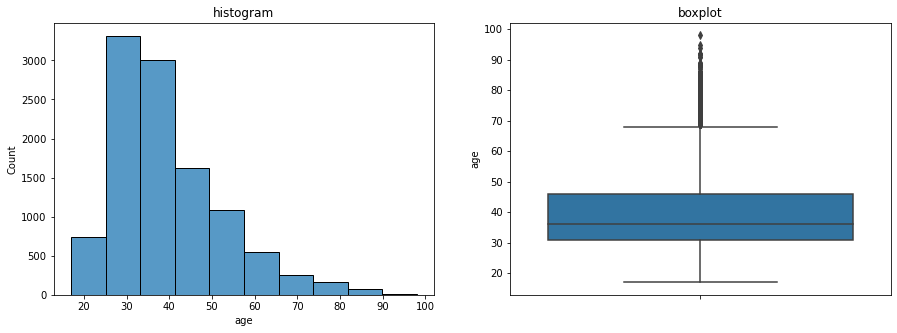

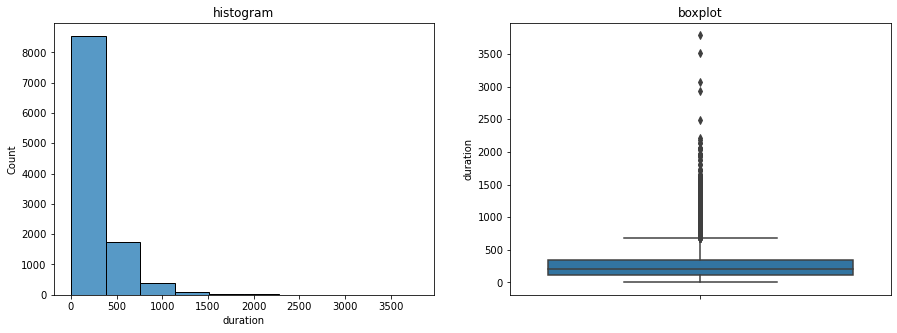

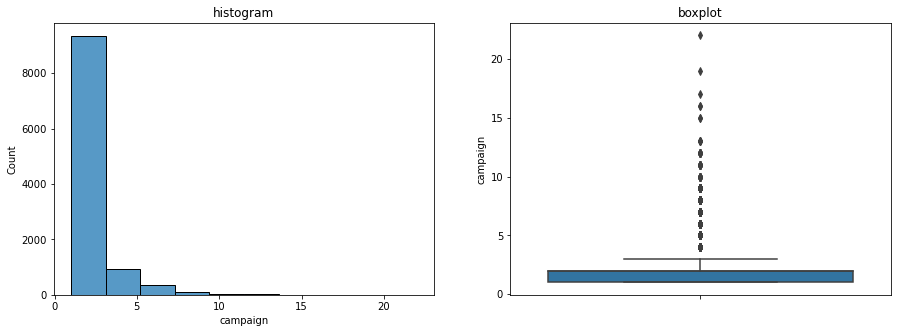

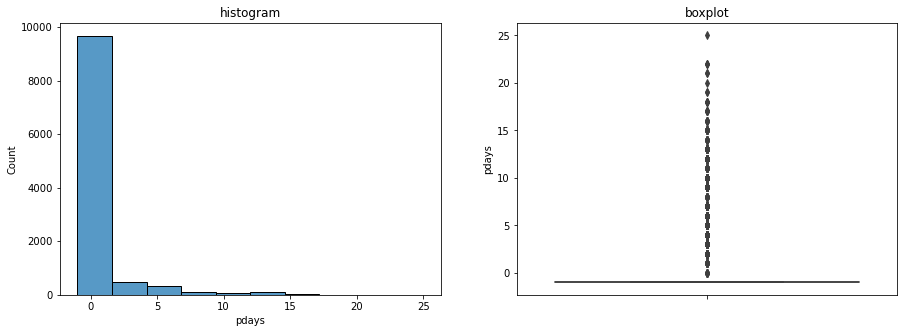

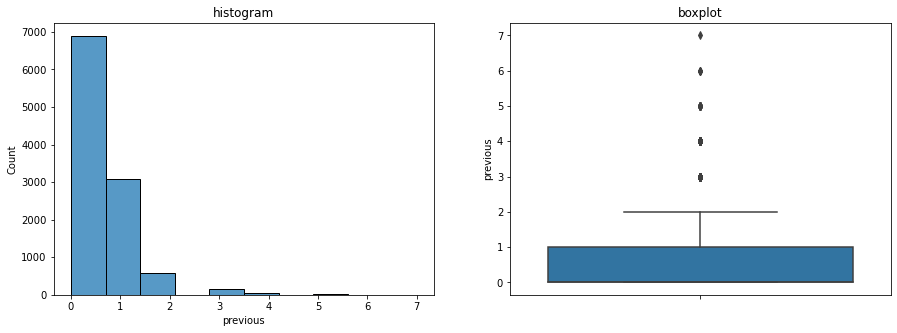

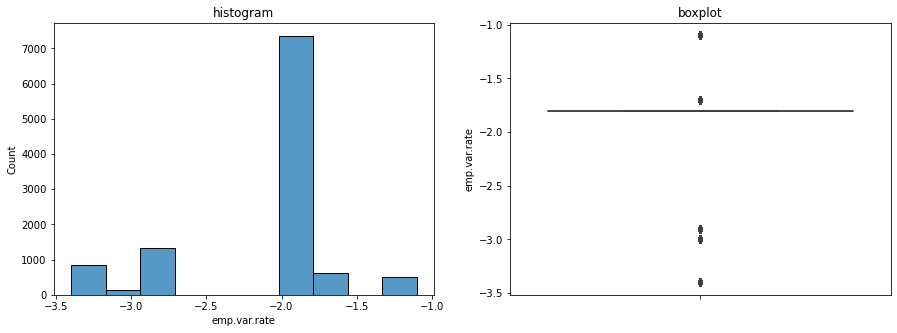

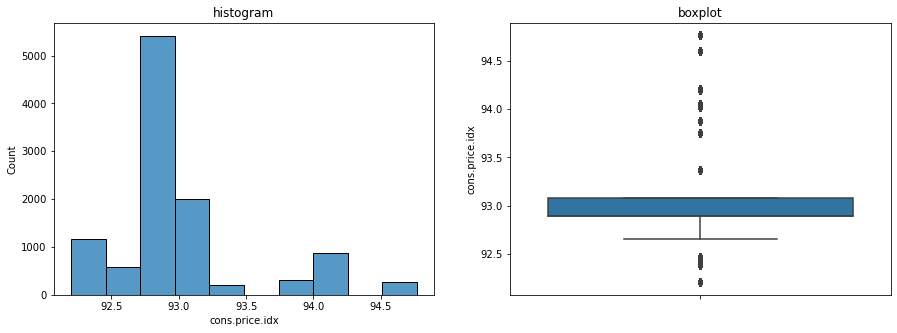

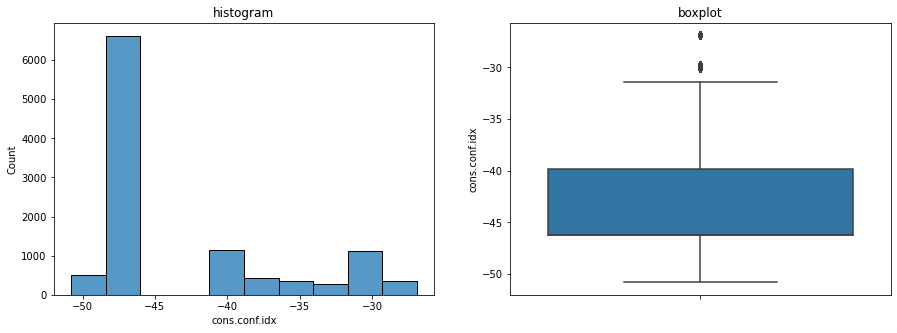

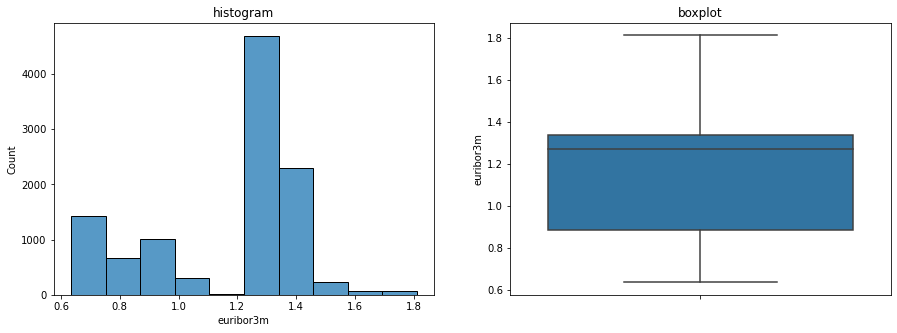

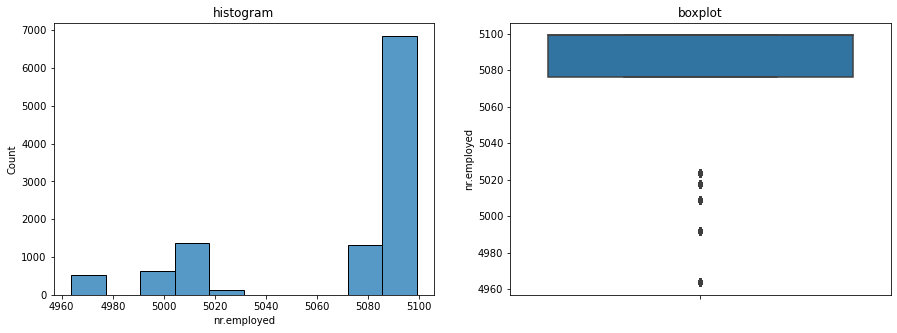

In [29]:
# numeric columns list
num_col = x_train.select_dtypes(include=np.number).columns.tolist()

# diagnostic_plots of numeric columns (data distribution, outlier detection)
for col in num_col:
    diagnostic_plots(x_train, col)

All columns data distribution are skew. From the boxplot, there isn't any outlier in 'euribor3m'.

In [30]:
# outlier columns list
outlier_skewed = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                  'cons.conf.idx', 'nr.employed']
boundary_skewed = {}

for col in outlier_skewed:
    boundary_skewed[col] = find_skewed_boundaries(x_train, col, 1.5)
    
# upper, lower boundary of outlier columns
boundary_skewed

{'age': (68.5, 8.5),
 'duration': (680.5, -227.5),
 'campaign': (3.5, -0.5),
 'pdays': (-1.0, -1.0),
 'previous': (2.5, -1.5),
 'emp.var.rate': (-1.8, -1.8),
 'cons.price.idx': (93.34800000000001, 92.62),
 'cons.conf.idx': (-30.19999999999999, -55.80000000000001),
 'nr.employed': (5133.450000000001, 5041.8499999999985)}

In [31]:
# outlier number, percentage in  outlier columns
for col in outlier_skewed:
    outlier_info(x_train, col, boundary_skewed)   

age
total number of data : 10805
right end outliers   : 405
left end outliers.   : 0
% right end outliers : 3.7482646922720964
% left end outliers  : 0.0

duration
total number of data : 10805
right end outliers   : 691
left end outliers.   : 0
% right end outliers : 6.395187413234614
% left end outliers  : 0.0

campaign
total number of data : 10805
right end outliers   : 1461
left end outliers.   : 0
% right end outliers : 13.521517815826007
% left end outliers  : 0.0

pdays
total number of data : 10805
right end outliers   : 1164
left end outliers.   : 0
% right end outliers : 10.772790374826469
% left end outliers  : 0.0

previous
total number of data : 10805
right end outliers   : 243
left end outliers.   : 0
% right end outliers : 2.248958815363258
% left end outliers  : 0.0

emp.var.rate
total number of data : 10805
right end outliers   : 1135
left end outliers.   : 2315
% right end outliers : 10.50439611291069
% left end outliers  : 21.42526608051828

cons.price.idx
total number

In [32]:
# capping columns list
outlier_col = ['age', 'duration', 'campaign', 'previous']

# split capping columns 
x_train_not_capped =x_train.drop(outlier_col, axis=1)
x_train_outlier = x_train[outlier_col]

In [33]:
# capping the outliers using winsorizer
winsorizer = Winsorizer(capping_method='iqr', tail='right', fold=1.5)
x_train_capped = winsorizer.fit_transform(x_train_outlier)
x_train = pd.concat([x_train_not_capped, x_train_capped], axis=1)

x_train_capped.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10805.0,39.397085,11.732165,17.0,31.0,36.0,46.0,68.5
duration,10805.0,251.232901,183.636134,0.0,113.0,200.0,340.0,680.5
campaign,10805.0,1.828644,0.934795,1.0,1.0,2.0,2.0,3.5
previous,10805.0,0.450578,0.664186,0.0,0.0,0.0,1.0,2.5


### Missing Value Handling

In [34]:
# null in datasets
print('null in x_train : ', x_train.isna().sum().sum())
print('null in y_train : ', y_train.isna().sum())
print('null in x_test  : ', x_test.isna().sum().sum())
print('null in y_test  : ', y_test.isna().sum())

null in x_train :  0
null in y_train :  0
null in x_test  :  0
null in y_test  :  0


see...

### Feature Selection

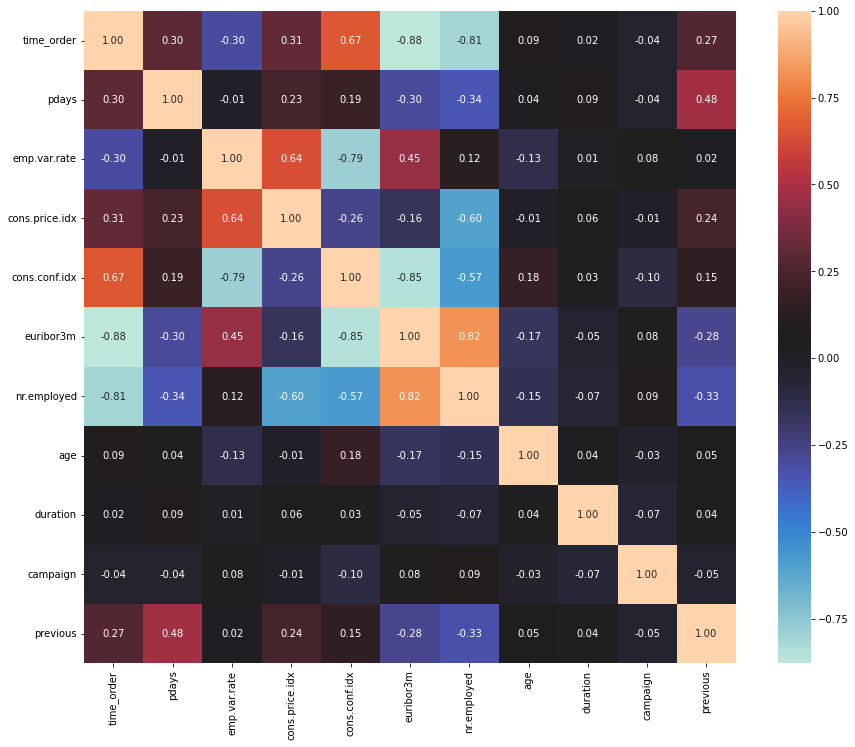

In [35]:
# feature correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(x_train.corr(), square=True, annot=True, fmt='.2f', cmap='icefire')
plt.show()

There aren't any extremely high correlation (<-0.9 or >0.9) between features.  

In [36]:
# selected features lists
num_select = ['pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
              'euribor3m', 'nr.employed']
cat_select = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
              'month', 'day_of_week', 'poutcome', 'age_group', 'campaign_group']
              
x_train_num = x_train[num_select]
x_test_num = x_test[num_select]

x_train_cat = x_train[cat_select]
x_test_cat = x_test[cat_select]

All features, except 'age' (redundant with 'age_group'), 'duration' (see input variable explanation), and 'campaign' (redundant with 'campaign_group'), are used in the model.

### Scaling and Encoding

In [37]:
# scaling using MinMaxScaler
scaler = MinMaxScaler() 
scaler.fit(x_train_num)

x_train_scaled = scaler.transform(x_train_num)
x_test_scaled = scaler.transform(x_test_num)

In [38]:
# encoding using OneHotEncoder
encoder = OneHotEncoder(sparse=False) 
encoder.fit(x_train_cat)

x_train_encoded = encoder.transform(x_train_cat)
x_test_encoded = encoder.transform(x_test_cat)

In [39]:
# putting it all together...
x_train_fix = np.column_stack([x_train_scaled, x_train_encoded])
x_test_fix = np.column_stack([x_test_scaled, x_test_encoded])

## Model Definition

In this section, several model algorithms are compared to find the best one. The models are cross-validated using recall (suitable for imbalance data) as the scoring metric.

In [40]:
# logistic regression
logreg = LogisticRegression()
cv_logreg = cross_val_score(logreg, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_logreg)
print('cv_mean  :', cv_logreg.mean())
print('cv_std   :', cv_logreg.std())

cv_score : [0.31558935 0.33396584 0.31688805 0.29601518 0.35863378]
cv_mean  : 0.32421843998239547
cv_std   : 0.0209906975839431


In [41]:
# support vector classification
svc = SVC()
cv_svc = cross_val_score(svc, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_svc)
print('cv_mean  :', cv_svc.mean())
print('cv_std   :', cv_svc.std())

cv_score : [0.25285171 0.26755218 0.29032258 0.24478178 0.28083491]
cv_mean  : 0.267268634425437
cv_std   : 0.016906300188836675


In [42]:
# decision tree
dectree = DecisionTreeClassifier(random_state=17)
cv_dectree = cross_val_score(dectree, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_dectree)
print('cv_mean  :', cv_dectree.mean())
print('cv_std   :', cv_dectree.std())

cv_score : [0.42965779 0.41555977 0.41745731 0.43074004 0.4743833 ]
cv_mean  : 0.4335596424268223
cv_std   : 0.021321474252467405


In [43]:
# random forest
rf = RandomForestClassifier(random_state=17)
cv_rf = cross_val_score(rf, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_rf)
print('cv_mean  :', cv_rf.mean())
print('cv_std   :', cv_rf.std())

cv_score : [0.37072243 0.40796964 0.39278937 0.35104364 0.43263757]
cv_mean  : 0.3910325322328122
cv_std   : 0.02839909403809668


In [44]:
# k-nearest neighbors
knn = KNeighborsClassifier()
cv_knn = cross_val_score(knn, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_knn)
print('cv_mean  :', cv_knn.mean())
print('cv_std   :', cv_knn.std())

cv_score : [0.30608365 0.32637571 0.34724858 0.33776091 0.34535104]
cv_mean  : 0.3325639786148729
cv_std   : 0.015137086933179155


In [45]:
# gaussian naive-bayes
g_nb = GaussianNB()
cv_gnb = cross_val_score(g_nb, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_gnb)
print('cv_mean  :', cv_gnb.mean())
print('cv_std   :', cv_gnb.std())

cv_score : [0.66539924 0.69259962 0.64516129 0.63187856 0.68500949]
cv_mean  : 0.6640096391800925
cv_std   : 0.023012945476840664


In [46]:
# multinomial naive-bayes
m_nb = MultinomialNB()
cv_mnb = cross_val_score(m_nb, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_mnb)
print('cv_mean  :', cv_mnb.mean())
print('cv_std   :', cv_mnb.std())

cv_score : [0.48098859 0.5256167  0.4914611  0.4573055  0.51612903]
cv_mean  : 0.49430018542434756
cv_std   : 0.024540122097821627


In [47]:
# complement naive-bayes
c_nb = ComplementNB()
cv_cnb = cross_val_score(c_nb, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_cnb)
print('cv_mean  :', cv_cnb.mean())
print('cv_std   :', cv_cnb.std())

cv_score : [0.70532319 0.71726755 0.70018975 0.68690702 0.72675522]
cv_mean  : 0.7072885477016762
cv_std   : 0.013770939869056814


In [48]:
# bernoulli naive-bayes
b_nb = BernoulliNB()
cv_bnb = cross_val_score(b_nb, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_bnb)
print('cv_mean  :', cv_bnb.mean())
print('cv_std   :', cv_bnb.std())

cv_score : [0.50190114 0.5313093  0.51233397 0.46679317 0.51802657]
cv_mean  : 0.5060728277573754
cv_std   : 0.021814067460004877


In [49]:
# categorical naive-bayes
cat_nb = CategoricalNB()
cv_catnb = cross_val_score(cat_nb, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_catnb)
print('cv_mean  :', cv_catnb.mean())
print('cv_std   :', cv_catnb.std())

cv_score : [0.59885932 0.64136622 0.60151803 0.59203036        nan]
cv_mean  : nan
cv_std   : nan


In [50]:
# gradient boost
grad = GradientBoostingClassifier(random_state=17)
cv_grad = cross_val_score(grad, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_grad)
print('cv_mean  :', cv_grad.mean())
print('cv_std   :', cv_grad.std())

cv_score : [0.34790875 0.34914611 0.33396584 0.31688805 0.37950664]
cv_mean  : 0.3454830773226744
cv_std   : 0.020626328227131462


In [51]:
# ada boost
ada = AdaBoostClassifier(random_state=17)
cv_ada = cross_val_score(ada, x_train_fix, y_train, scoring='recall', cv=5, n_jobs=-1)

print('cv_score :', cv_ada)
print('cv_mean  :', cv_ada.mean())
print('cv_std   :', cv_ada.std())

cv_score : [0.32889734 0.33396584 0.31688805 0.32447818 0.36053131]
cv_mean  : 0.33295214320243
cv_std   : 0.014885850652895308


The model with the highest recall mean is complement naive-bayes, thus the best. 

## Model Training

There are 2 hyperparameters tested using GridSearchCV, as follows (from sklearn documentation):
1. alpha : float, default=1.0<br/>
Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
2. norm : bool, default=False<br/>
Whether or not a second normalization of the weights is performed. The default behavior mirrors the implementations found in Mahout and Weka, which do not follow the full algorithm described in Table 9 of the paper.

In [52]:
# GridSearchCV 
param_grid = {'alpha':[float(x) for x in np.linspace(0, 1, 11)], 
              'norm':[True, False]}

grid = GridSearchCV(c_nb, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)
grid.fit(x_train_fix, y_train)

D:\anaconda3\envs\yes_milord\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                   0.6000000000000001, 0.7000000000000001, 0.8,
                                   0.9, 1.0],
                         'norm': [True, False]},
             scoring='recall')

In [53]:
# GridSeachCV best parameters
grid.best_params_

{'alpha': 0.0, 'norm': False}

The difference between base and GridSeachCV best hyperparameters is 'alpha' value set to 0 (no smoothing) in GridSeachCV model.

## Model Evaluation

In [54]:
# fitting the best parameters
grid_best_est = grid.best_estimator_

In [55]:
# predict the train data
y_pred_train = grid_best_est.predict(x_train_fix)
print(confusion_matrix(y_train, y_pred_train))
print('')
print(classification_report(y_train, y_pred_train))
print('')
print(roc_auc_score(y_train, y_pred_train))

[[5900 2271]
 [ 761 1873]]

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      8171
           1       0.45      0.71      0.55      2634

    accuracy                           0.72     10805
   macro avg       0.67      0.72      0.67     10805
weighted avg       0.78      0.72      0.74     10805


0.7165758218385725


In [56]:
# predict the test data
y_pred = grid_best_est.predict(x_test_fix)
print(confusion_matrix(y_test, y_pred))
print('')
print(classification_report(y_test, y_pred))
print('')
print(roc_auc_score(y_test, y_pred))

[[1438  560]
 [ 201  458]]

              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1998
           1       0.45      0.69      0.55       659

    accuracy                           0.71      2657
   macro avg       0.66      0.71      0.67      2657
weighted avg       0.77      0.71      0.73      2657


0.7073560662331528


The test data has a similar metrics score to train data. Both have a low group 1 precision and a balanced recall between group 0 and 1. This shows the model doesn't overfit.

D:\anaconda3\envs\yes_milord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


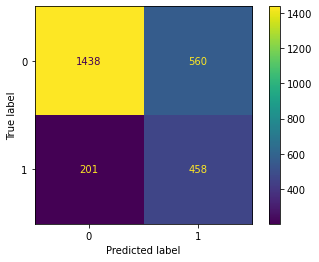

In [57]:
# confusion matrix plot (test data)
plot_confusion_matrix(grid_best_est, x_test_fix, y_test)

Group 1 ('yes') correlation matrix (test data) :<br/>
true positive = 458<br/>
true negative  = 1438<br/>
false positive = 560<br/>
false negative = 201

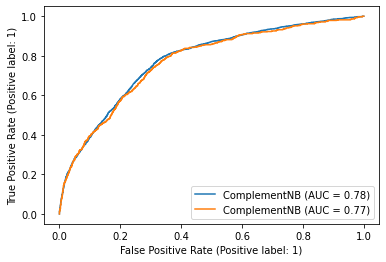

In [58]:
# train vs test roc curve
ax = plt.gca()
train_disp = RocCurveDisplay.from_estimator(grid_best_est, x_train_fix, y_train, ax=ax)
test_disp = RocCurveDisplay.from_estimator(grid_best_est, x_test_fix, y_test, ax=ax)
plt.show()

The test roc-curve fits smoothly to the train  roc-curve. Both train and test data show similar roc-auc score.

## Model Inference

In [59]:
data_inf =  data_inf[data_inf.euribor3m <= 1.811]

age_group_col(data_inf)
campaign_group_col(data_inf)

In [60]:
data_inf.job.replace('unknown','unemployed', inplace=True)
data_inf.marital.replace('unknown','single', inplace=True)
data_inf.education.replace('illiterate','unknown', inplace=True)
data_inf.default.replace('yes','unknown', inplace=True)

In [61]:
x_inf = data_inf.drop(['y'], axis=1)
y_inf = data_inf['y']

In [62]:
# retracing the steps...
x_inf_num = x_inf[num_select]
x_inf_cat = x_inf[cat_select]

x_inf_scaled = scaler.transform(x_inf_num)
x_inf_encoded = encoder.transform(x_inf_cat)

x_inf_fix = np.column_stack([x_inf_scaled, x_inf_encoded])

In [63]:
# merging to the original inferece data
y_pred_inf = grid_best_est.predict(x_inf_fix)
y_pred_inf = grid_best_est.predict(x_inf_fix)
y_pred_inf_df = pd.DataFrame(y_pred_inf, index=data_inf.index, columns=['y_model'])
data_inf_model = pd.concat([data_inf, y_pred_inf_df], axis=1)
data_inf_model

,time_order,age,job,marital,education,default,housing,loan,contact,month,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,campaign_group,y_model
0,40718,86,retired,married,unknown,unknown,yes,yes,cellular,sep,...,success,-1.1,94.199,-37.5,0.877,4963.6,1,over 66,1,1
1,37511,41,blue-collar,married,basic.9y,no,no,no,cellular,aug,...,failure,-2.9,92.201,-31.4,0.873,5076.2,0,37-46,1,0
6,35658,39,technician,single,university.degree,no,yes,no,cellular,may,...,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,1,37-46,1,0
8,39949,69,retired,divorced,professional.course,no,yes,no,telephone,jun,...,nonexistent,-1.7,94.055,-39.8,0.748,4991.6,0,over 66,"4,5",1
9,30136,58,retired,married,basic.4y,no,yes,no,cellular,apr,...,success,-1.8,93.075,-47.1,1.365,5099.1,0,57-66,1,1
10,30754,44,services,married,high.school,no,yes,no,cellular,may,...,failure,-1.8,92.893,-46.2,1.344,5099.1,0,37-46,1,0
12,35499,23,blue-collar,single,high.school,no,yes,no,cellular,may,...,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0,under 27,1,0
13,36293,33,unemployed,single,university.degree,no,no,no,telephone,jun,...,failure,-2.9,92.963,-40.8,1.266,5076.2,0,27-36,1,1
18,35795,36,admin.,single,university.degree,no,no,no,telephone,may,...,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0,27-36,"4,5",0
27,27760,34,technician,single,professional.course,no,yes,no,cellular,mar,...,nonexistent,-1.8,92.843,-50.0,1.726,5099.1,1,27-36,1,1


D:\anaconda3\envs\yes_milord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


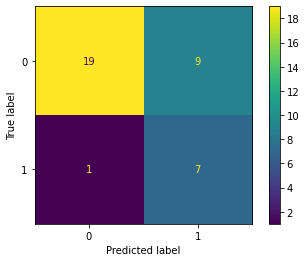

In [64]:
plot_confusion_matrix(grid_best_est, x_inf_fix, y_inf)

The order between TP, TN, FP, FN in inference data is consistent with train and test data.

## Conclusion

Only data from 2009 onwards are used for the model. The best model algorithm is complement naive-bayes. It performs quite well, especially for predicting positive term deposit subsription (70% recall).